# Decoding Responsivity (imbalanced learn)
**Can we predict whether a stimulus will be detected or not based on neuron's responsivity ?**

Célien Vandromme
18/04/2024

---

In [33]:
from unittest import result

import numpy as np
import pandas as pd


import percephone.core.recording as pc
import percephone.plts.stats as ppt
import os
import matplotlib
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count, pool
import warnings
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from scipy.stats import mannwhitneyu
import imblearn as imb
from percephone.analysis.neuron_var import neuron_mean_std_corr

plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline
warnings.filterwarnings('ignore')
fontsize = 30
%config InlineBackend.figure_format = 'retina'

In [34]:
user = "Théo"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    
roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    rec.peak_delay_amp()
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
    pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorpor

In [35]:
names = ["ID", "genotype", "stim", "stim_True", "stim_False", "neuron_exc", "neuron_inh"]
matrix = []
for rec in recs.values():
    ind = []
    ind.append(rec.filename)
    ind.append(rec.genotype)
    ind.append(len(rec.detected_stim))
    ind.append(rec.detected_stim.sum())
    ind.append(len(rec.detected_stim) - rec.detected_stim.sum())
    ind.append(rec.matrices["EXC"]["Responsivity"].shape[0])
    ind.append(rec.matrices["INH"]["Responsivity"].shape[0])
    matrix.append(ind)
summary = pd.DataFrame(np.array(matrix), columns=names)
summary

,ID,genotype,stim,stim_True,stim_False,neuron_exc,neuron_inh
0,5889,WT,54,46,8,49,15
1,6601,KO-Hypo,62,28,34,103,22
2,4939,WT,54,25,29,101,19
3,5893,KO,80,37,43,58,13
4,5886,WT,82,65,17,38,9
5,4456,WT,87,58,29,127,14
6,6611,KO-Hypo,66,9,57,84,18
7,5873,WT,27,19,8,91,29
8,5881,KO-Hypo,53,24,29,103,19
9,5879,WT,68,45,23,55,18


In [36]:
def resp_heatmap(record_dict, sort=False):
    if sort:
        X_train_true = record_dict["X_train"][record_dict["y_train"] == True]
        y_train_true = np.ones(X_train_true.shape[0], dtype=bool)
        X_train_false = record_dict["X_train"][record_dict["y_train"] == False]
        y_train_false = np.zeros(X_train_false.shape[0], dtype=bool)
        X_new = record_dict["X_bal"][X_train_true.shape[0] + X_train_false.shape[0]:]
        y_new = record_dict["y_bal"][X_train_true.shape[0] + X_train_false.shape[0]:]
        X = np.row_stack((X_train_true, X_train_false, X_new))
        y = np.append(y_train_true, np.append(y_train_false, y_new))
    else:
        X = record_dict["X_bal"]
        y = record_dict["y_bal"]

    plt.figure(figsize=(12, 6))
    sns.heatmap(X.T, cmap='plasma', xticklabels=y, cbar_kws={'label': 'Responsivity'})
    plt.axvline(x=record_dict["X_train"].shape[0], color="black", linewidth=1)
    if sort:
        plt.axvline(x=X_train_true.shape[0], color="black", linewidth=1, linestyle='dashed')
    plt.title(f"{record_dict['filename']}({record_dict['genotype']}) Neuron Responses to Stimuli")
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.xlabel("Detected stimulation")
    plt.ylabel("Neurons")
    plt.show()

In [37]:
def get_rec_info(rec, parameter, estimator=None, exc_neurons=True, inh_neurons=False):
    result = {}
    result["genotype"] = rec.genotype
    result["filename"] = rec.filename
    result["threshold"] = rec.threshold
    result["stim_ampl"] = rec.stim_ampl
    result["y"] = rec.detected_stim
    
    if parameter == "zscore":
        exc_data = np.empty((0, rec.zscore_exc.shape[0]))
        inh_data = np.empty((0, rec.zscore_inh.shape[0]))
        for i, start in enumerate(rec.stim_time):
            end = start + int(rec.stim_durations[i])
            new_exc = neuron_mean_std_corr(rec.zscore_exc[:, start : end].T, estimator)
            new_inh = neuron_mean_std_corr(rec.zscore_inh[:, start : end].T, estimator)
            exc_data = np.row_stack((exc_data, new_exc))
            inh_data = np.row_stack((inh_data, new_inh))
        exc_data = exc_data.T
        inh_data = inh_data.T
    else:
        exc_data = rec.matrices["EXC"][parameter]
        inh_data = rec.matrices["INH"][parameter]
    
    if exc_neurons and inh_neurons:
        result["X"] = np.row_stack((exc_data, inh_data)).T
        result["neurons"] = "EXC & INH"
    elif exc_neurons:
        result["X"] = exc_data.T
        result["neurons"] = "EXC"
    elif inh_neurons:
        result["X"] = inh_data.T
        result["neurons"] = "INH"
    return result

In [38]:
def stim_ampl_filter(record, stim_ampl="all"):
    all_ampl = np.arange(0, 14, 2)
    if stim_ampl == "threshold":
        amplitudes = record["threshold"]
    elif stim_ampl == "supra":
        amplitudes = all_ampl[all_ampl >= record["threshold"]]
    elif stim_ampl == "sub":
        amplitudes = all_ampl[all_ampl < record["threshold"]]
    elif stim_ampl == "all":
        return record
    else:
        amplitudes = np.array(stim_ampl)
    selected_stim = np.isin(record["stim_ampl"], amplitudes)
    record["X"] = record["X"][selected_stim]
    record["y"] = record["y"][selected_stim]
    return record

In [39]:
def split_data(record_dict, train_ratio=0.8, stratify=False, seed=None):
    if stratify:
        record_dict["X_train"], record_dict["X_test"], record_dict["y_train"], record_dict["y_test"] = train_test_split(record_dict["X"], record_dict["y"], 
                                                                                                                        train_size=train_ratio,
                                                                                                                        stratify=record_dict["y"],
                                                                                                                        random_state=seed)
    else:
        record_dict["X_train"], record_dict["X_test"], record_dict["y_train"], record_dict["y_test"] = train_test_split(record_dict["X"], record_dict["y"], 
                                                                                                                        train_size=train_ratio,
                                                                                                                        stratify=None,
                                                                                                                        random_state=seed)
    return record_dict

In [40]:
def resample(record_dict, resampler):
    record_dict["X_bal"], record_dict["y_bal"] = resampler.fit_resample(record_dict["X_train"], record_dict["y_train"])
    return record_dict

In [43]:
def apply_model(model, parameter, estimator=None, resampler=None, exc_neurons=True, inh_neurons=True, amplitudes="all", train_ratio=0.8, stratify=True, cv=10, seed=None):
    mean_cv_scores = [[], [], []]
    accuracies = [[], [], []]
    sensitivities = [[], [], []]
    specificities = [[], [], []]
    models_dict = {}
    
    fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(15, 10), sharex=True)
    i_wt = 0
    i_ko = 0
        
    for rec in recs.values():
        
        # Defining the variable gen_id according to genotype, used to group accuracies, sensitivities, ...etc by genotype
        if rec.genotype == "WT":
            genotype_id = 0
        elif rec.genotype == "KO-Hypo":
            genotype_id = 1
        elif rec.genotype == "KO":
            genotype_id = 2
        
        try:
            record = get_rec_info(rec, parameter, estimator=estimator, exc_neurons=exc_neurons, inh_neurons=inh_neurons)
            record = stim_ampl_filter(record, stim_ampl=amplitudes)
            record = split_data(record, train_ratio=train_ratio, stratify=stratify, seed=seed)
            test_size = record["y_test"].shape[0]
            
            if resampler is not None:
                record = resample(record, resampler)
                new_samples = record["y_bal"].shape[0] - record["y_train"].shape[0]
                model.fit(record["X_bal"], record["y_bal"])
                cv_scores = cross_val_score(model, record["X_bal"], record["y_bal"], cv=cv)
                # Generated label
                gen_lab = str(record["y_bal"][-1])
            else:
                new_samples = 0
                model.fit(record["X_train"], record["y_train"])
                cv_scores = cross_val_score(model, record["X_train"], record["y_train"], cv=cv)
        except ValueError:
            continue
            
        # Saving model for plotting the weights
        models_dict[f"{record['filename']} ({record['genotype']})"] = copy.copy(model)
        
        # Cross-validation
        mean_cv_scores[genotype_id].append(cv_scores.mean())
        
        # Metrics on test data
        y_pred = model.predict(record["X_test"])
        conf_matrix = confusion_matrix(record["y_test"], y_pred, labels=[False, True])
        TP = conf_matrix[1, 1]
        TN = conf_matrix[0, 0]
        FP = conf_matrix[0, 1]
        FN = conf_matrix[1, 0]

        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        accuracies[genotype_id].append(accuracy)
        sensitivities[genotype_id].append(sensitivity)
        specificities[genotype_id].append(specificity)
        
        # Boxplot of each recording
        if rec.genotype == "WT":
            i = copy.copy(i_wt)
            j = 0
            i_wt += 1
        else:
            i = copy.copy(i_ko)
            j = 1
            i_ko += 1
        
        ax[i, j].boxplot(cv_scores, vert=False, widths=.4)
        ax[i, j].scatter(cv_scores, np.ones(cv), s=10)
        ax[i, j].axvline(x=specificity, color="green", linewidth=1, linestyle=":")
        ax[i, j].axvline(x=sensitivity, color="orange", linewidth=1, linestyle=":")
        ax[i, j].axvline(x=accuracy, color="red", linewidth=1, linestyle=":")
        if resampler is not None:
            ax[i, j].set_title(f"{rec.filename} ({rec.genotype})[{record['y_bal'].shape[0]}N:{new_samples}({gen_lab}) T:{test_size}] - CV({cv_scores.mean():.1%}) Ac({accuracy:.1%}) Sp({specificity:.1%}) Se({sensitivity:.1%})", size=10)
        else:
            ax[i, j].set_title(f"{rec.filename} ({rec.genotype})[T:{test_size}] - CV({cv_scores.mean():.1%}) Ac({accuracy:.1%}) Sp({specificity:.1%}) Se({sensitivity:.1%})", size=10)
        ax[i, j].spines["left"].set_visible(True)
    plt.suptitle(f"Decoding {parameter} [{resampler}/{model}] - Train size: {train_ratio:.1%} - CV: {cv} fold")
    plt.show()
    
    # Boxplots of sensitivity, specificity and accuracy by genotype
    data_wt = [sensitivities[0], specificities[0], accuracies[0]]
    data_koh = [sensitivities[1], specificities[1], accuracies[1]]
    ppt.boxplot_3_conditions(data_wt, data_koh, cond_labels=["Detected", "Undetected", "All"], y_percent=True, 
                             title=f"Decoding {parameter} [{resampler}/{model}]", filename="model_metrics", label_y="Accuracy")

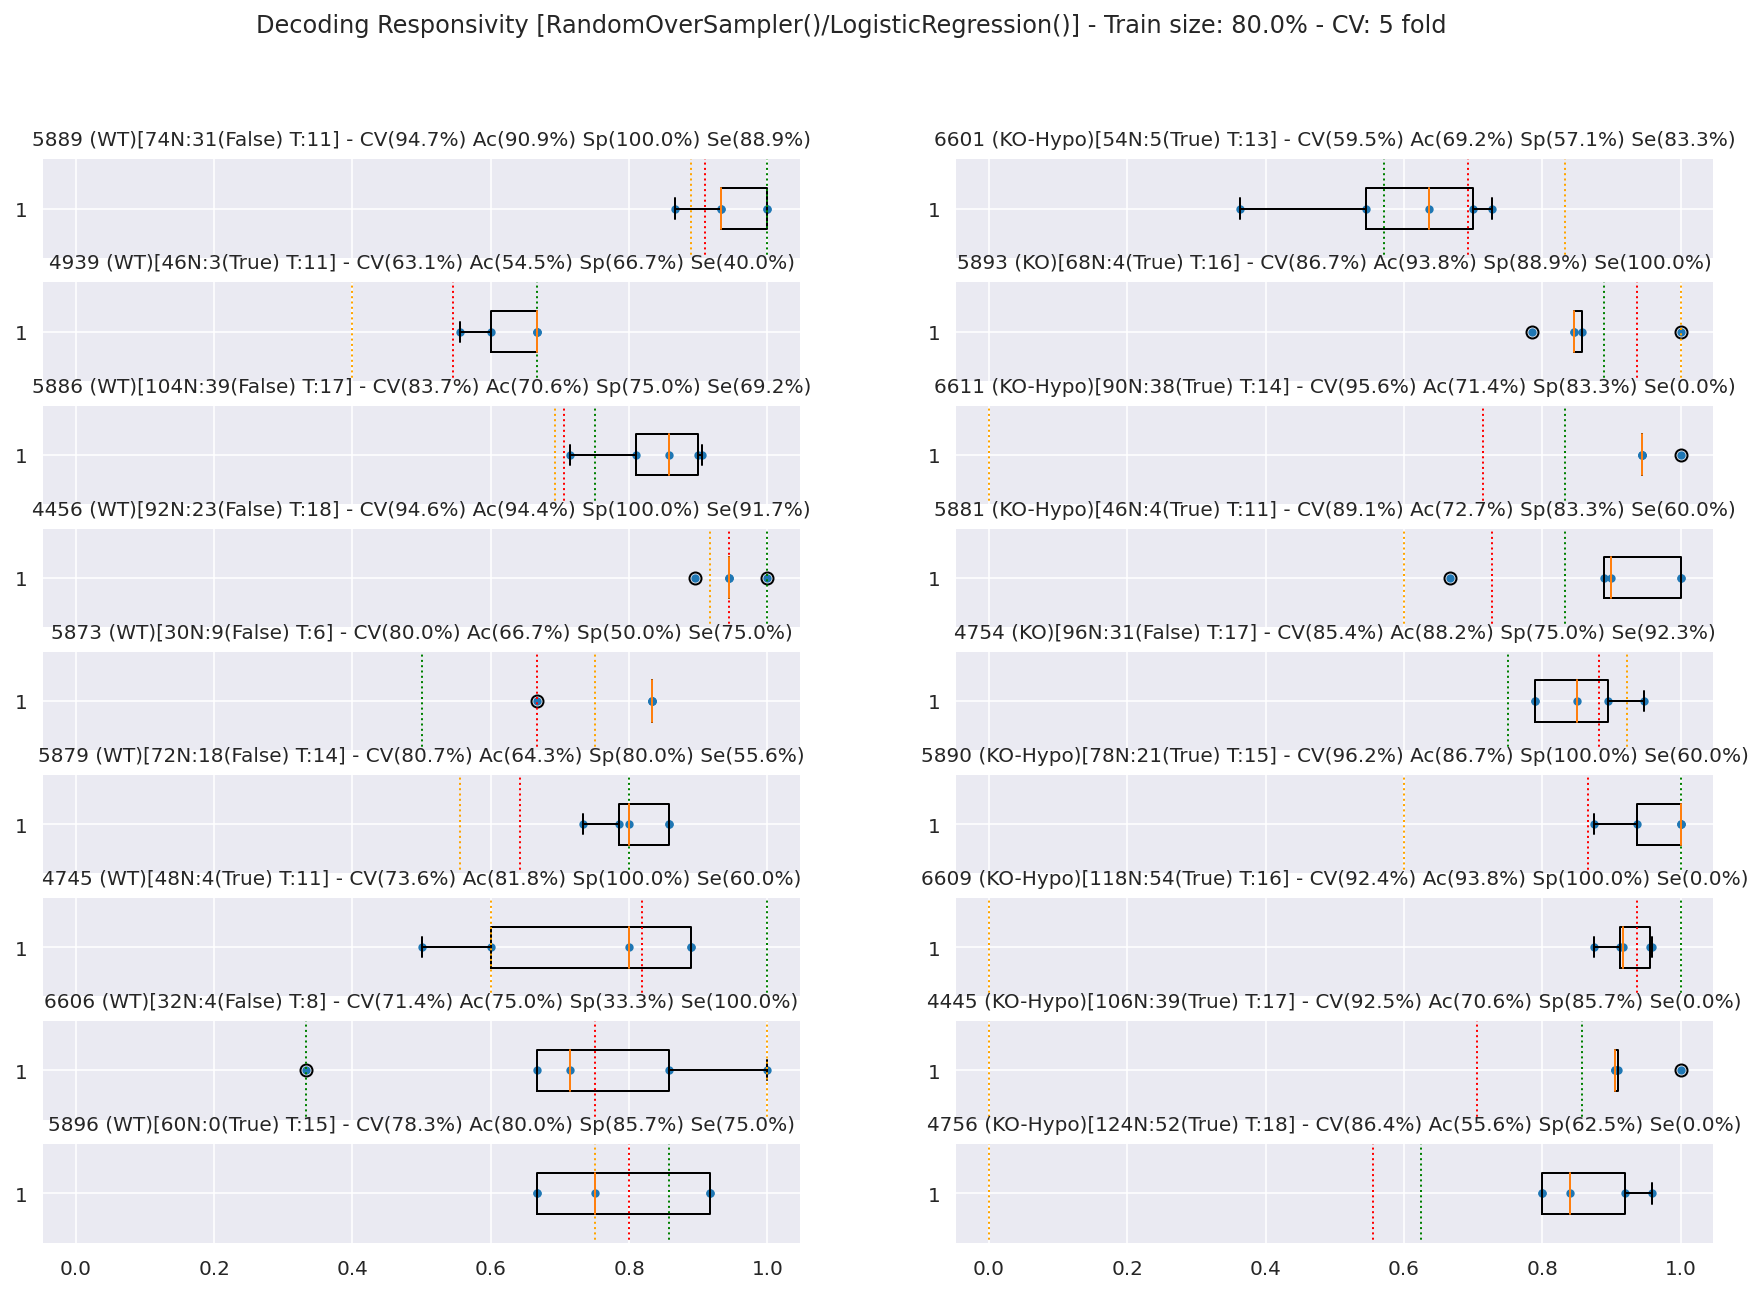

--- Detected group comp ---
ShapiroResult(statistic=0.974998950958252, pvalue=0.9337787628173828)
ShapiroResult(statistic=0.7494378685951233, pvalue=0.012517264112830162)
MannwhitneyuResult(statistic=52.0, pvalue=0.03229278647055528)
--- Undetected group comp ---
ShapiroResult(statistic=0.9007532596588135, pvalue=0.25639623403549194)
ShapiroResult(statistic=0.8869079947471619, pvalue=0.25891926884651184)
LeveneResult(statistic=0.8562854935315708, pvalue=0.3704568287890688)
Equal variances :Ttest_indResult(statistic=-0.47336234296288787, pvalue=0.6432509785369098)
--- All group comp ---
ShapiroResult(statistic=0.9801521301269531, pvalue=0.9650518894195557)
ShapiroResult(statistic=0.9256730675697327, pvalue=0.5147297382354736)
LeveneResult(statistic=0.21001134974569402, pvalue=0.6537912114741629)
Equal variances :Ttest_indResult(statistic=0.16940568022147007, pvalue=0.8679009735446391)


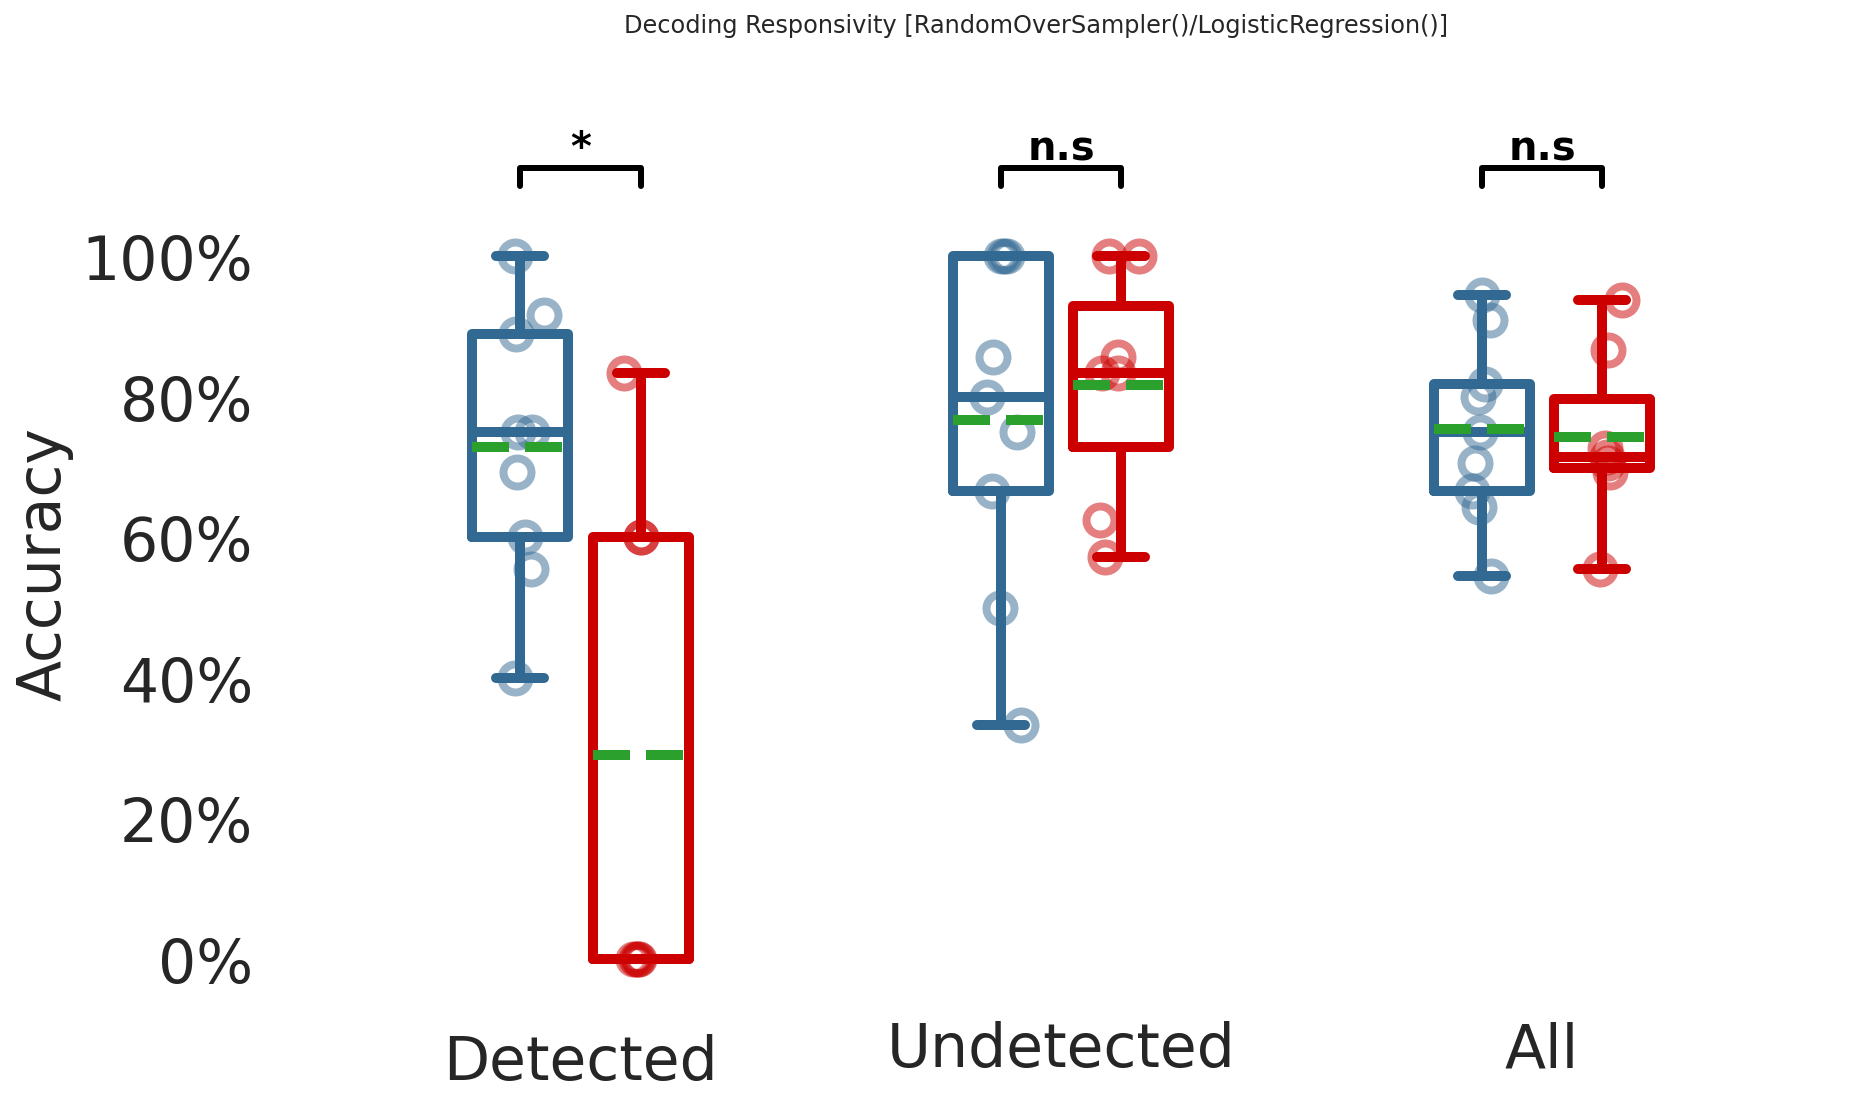

In [44]:
seed = 42

# Models
dum = DummyClassifier()
lr = LogisticRegression(penalty="l2")

# Resamplers
ros = imb.over_sampling.RandomOverSampler(sampling_strategy='auto', shrinkage=None)
smote = imb.over_sampling.SMOTE(sampling_strategy='auto')
adasyn = imb.over_sampling.ADASYN(sampling_strategy='auto')

apply_model(lr, "Responsivity", resampler=ros, exc_neurons=True, inh_neurons=True, amplitudes="all", train_ratio=0.8, cv=5, stratify=True, seed=seed)

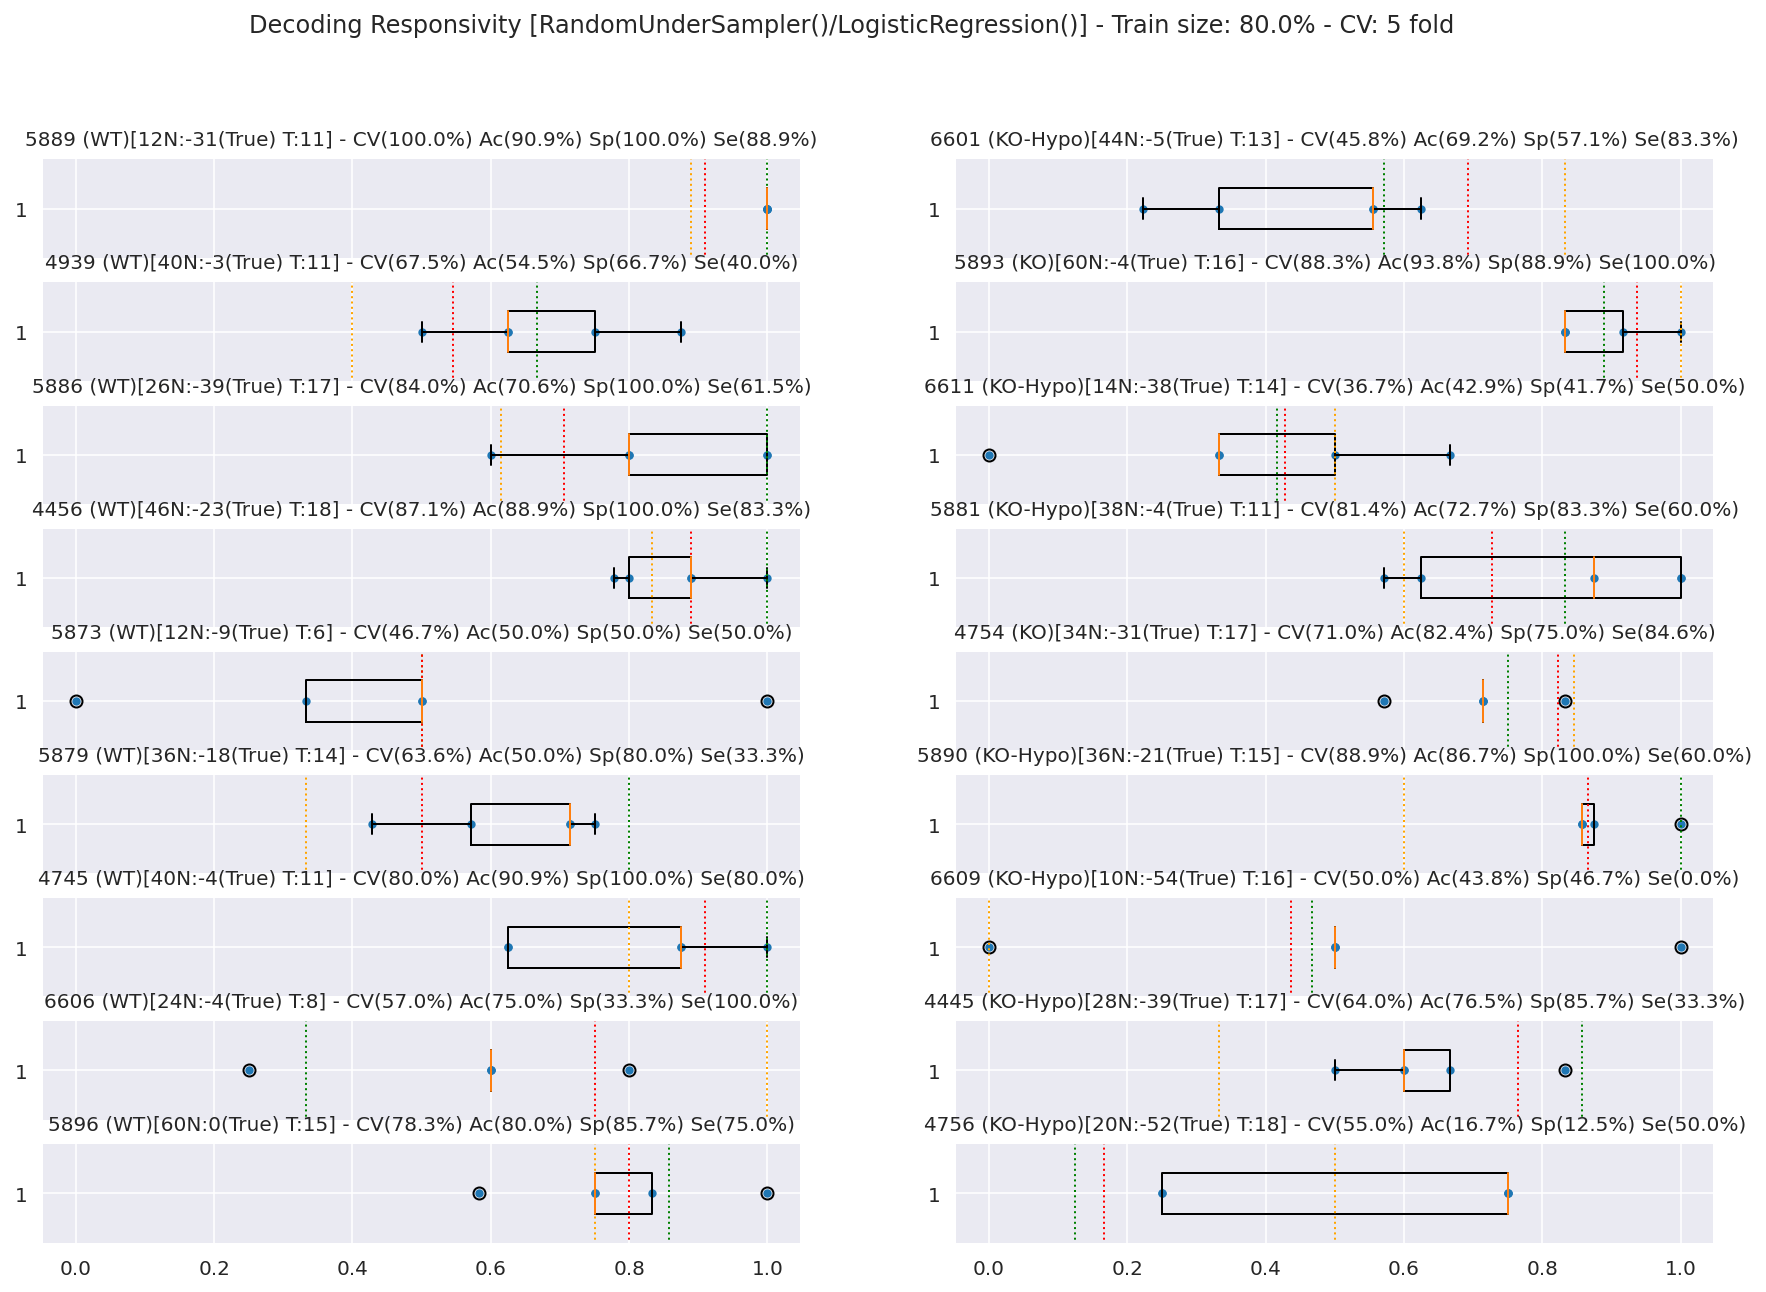

--- Detected group comp ---
ShapiroResult(statistic=0.9497913718223572, pvalue=0.6877729892730713)
ShapiroResult(statistic=0.9282876253128052, pvalue=0.5364319682121277)
LeveneResult(statistic=0.0322705761474624, pvalue=0.8600091886896986)
Equal variances :Ttest_indResult(statistic=1.622666074831676, pvalue=0.12695618759662736)
--- Undetected group comp ---
ShapiroResult(statistic=0.8373969197273254, pvalue=0.0540253147482872)
ShapiroResult(statistic=0.956692099571228, pvalue=0.7899044752120972)
LeveneResult(statistic=0.39830339307551466, pvalue=0.5381347008092385)
Equal variances :Ttest_indResult(statistic=1.3442958247184138, pvalue=0.2002315108757713)
--- All group comp ---
ShapiroResult(statistic=0.8646284937858582, pvalue=0.10763005167245865)
ShapiroResult(statistic=0.9192442297935486, pvalue=0.4635433852672577)
LeveneResult(statistic=0.5227026045434772, pvalue=0.48159584651758114)
Equal variances :Ttest_indResult(statistic=1.340508418803213, pvalue=0.20142864916432557)


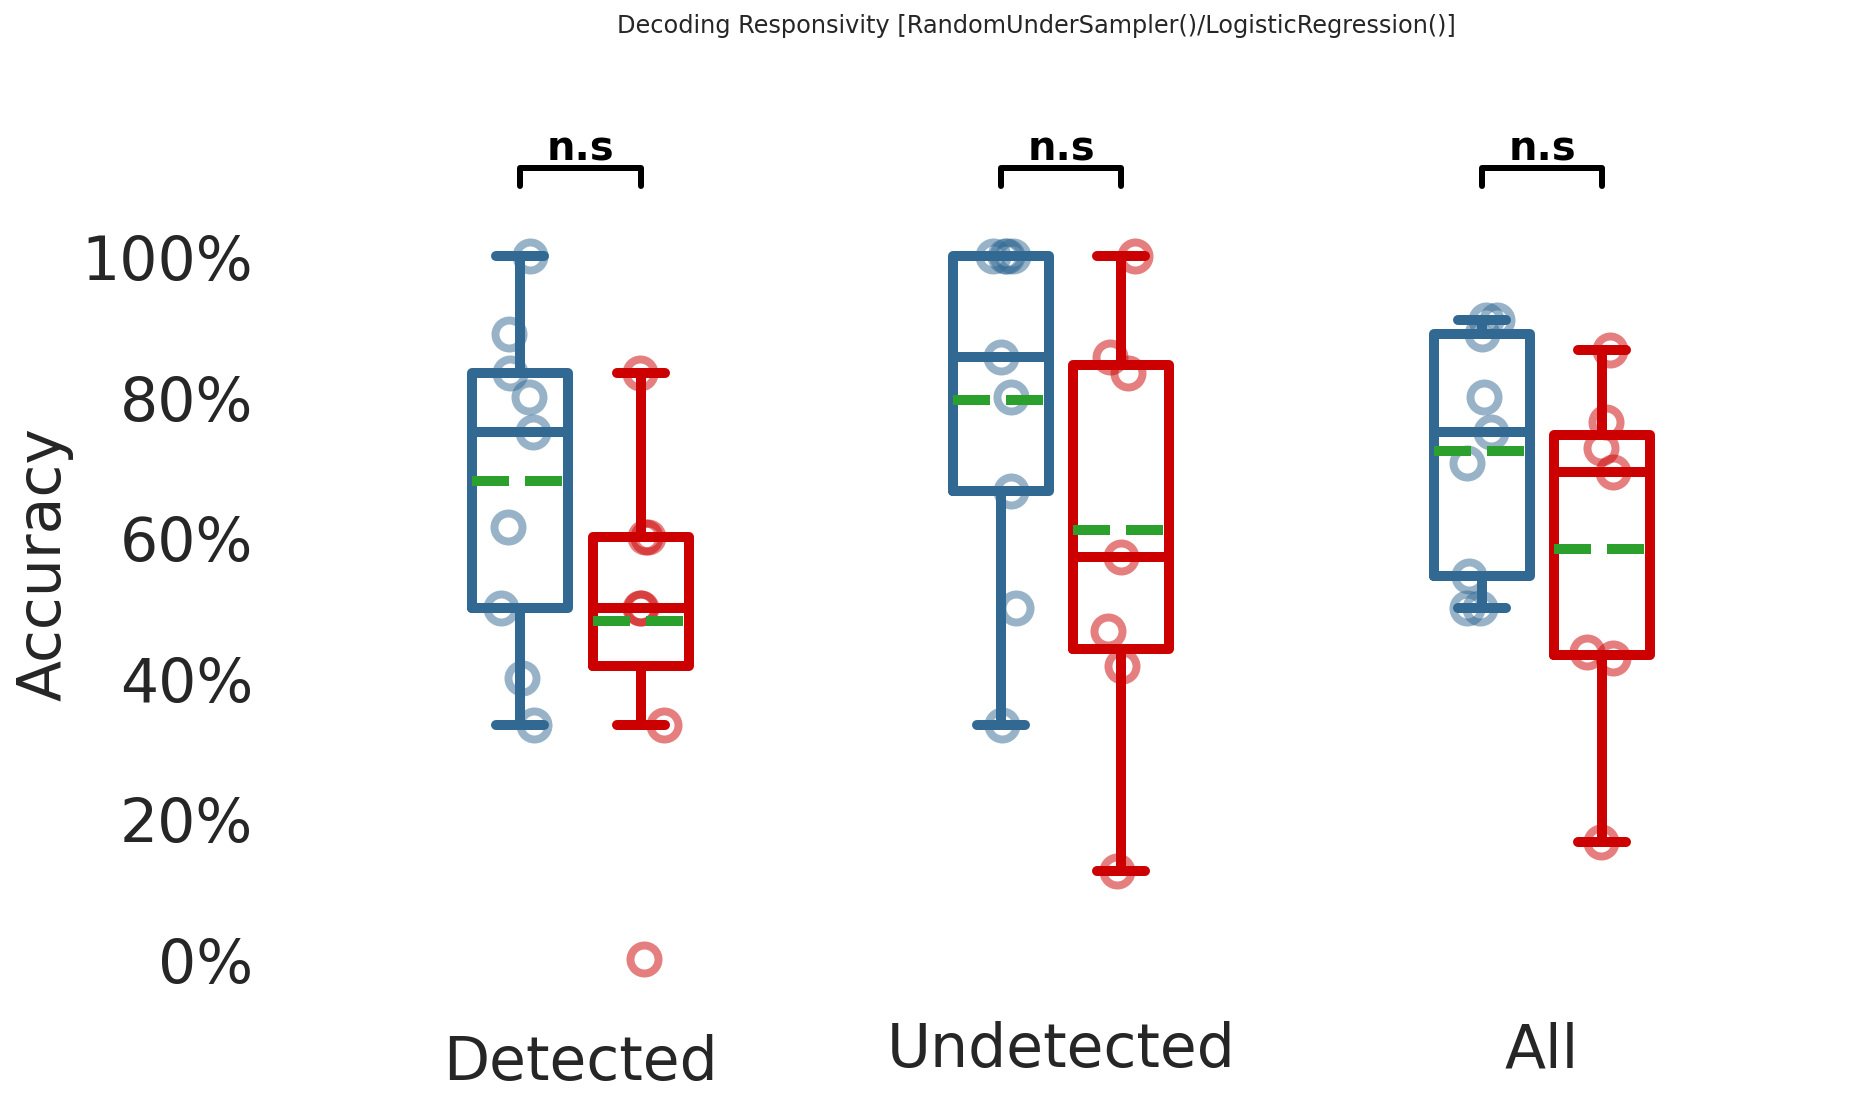

In [48]:
rus = imb.under_sampling.RandomUnderSampler(sampling_strategy="auto")
apply_model(lr, "Responsivity", estimator=None, resampler=rus, exc_neurons=True, inh_neurons=True, amplitudes="all", train_ratio=0.8, cv=5, stratify=True, seed=seed)

# Decoding mean Z-score

---

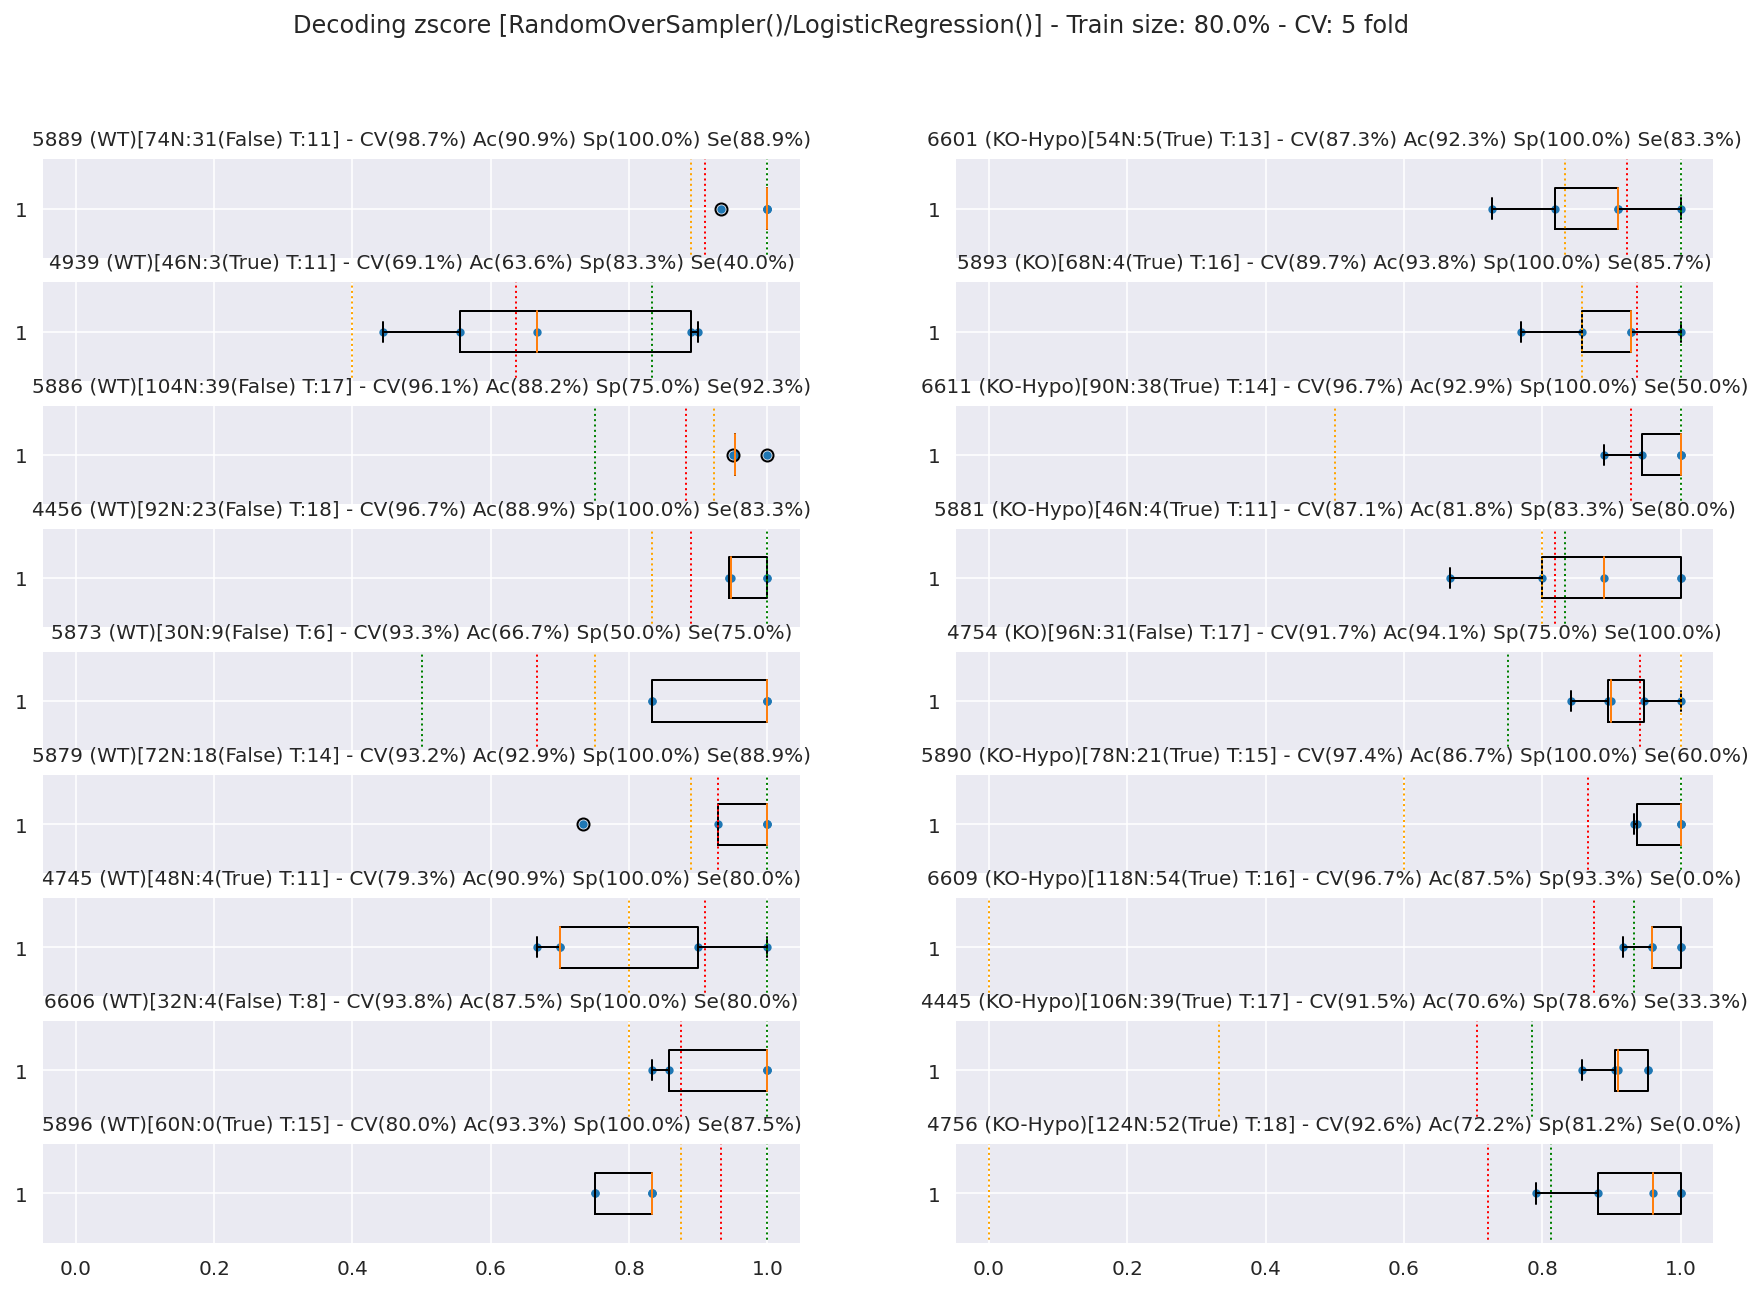

--- Detected group comp ---
ShapiroResult(statistic=0.7132964134216309, pvalue=0.0020287102088332176)
ShapiroResult(statistic=0.8972384929656982, pvalue=0.31458568572998047)
MannwhitneyuResult(statistic=53.5, pvalue=0.022160462419657728)
--- Undetected group comp ---
ShapiroResult(statistic=0.6755999326705933, pvalue=0.0007359705050475895)
ShapiroResult(statistic=0.8215363025665283, pvalue=0.06643927097320557)
MannwhitneyuResult(statistic=35.5, pvalue=0.6828234784162777)
--- All group comp ---
ShapiroResult(statistic=0.7062757611274719, pvalue=0.0016800444573163986)
ShapiroResult(statistic=0.8837732076644897, pvalue=0.24373047053813934)
MannwhitneyuResult(statistic=38.0, pvalue=0.5244421276890237)


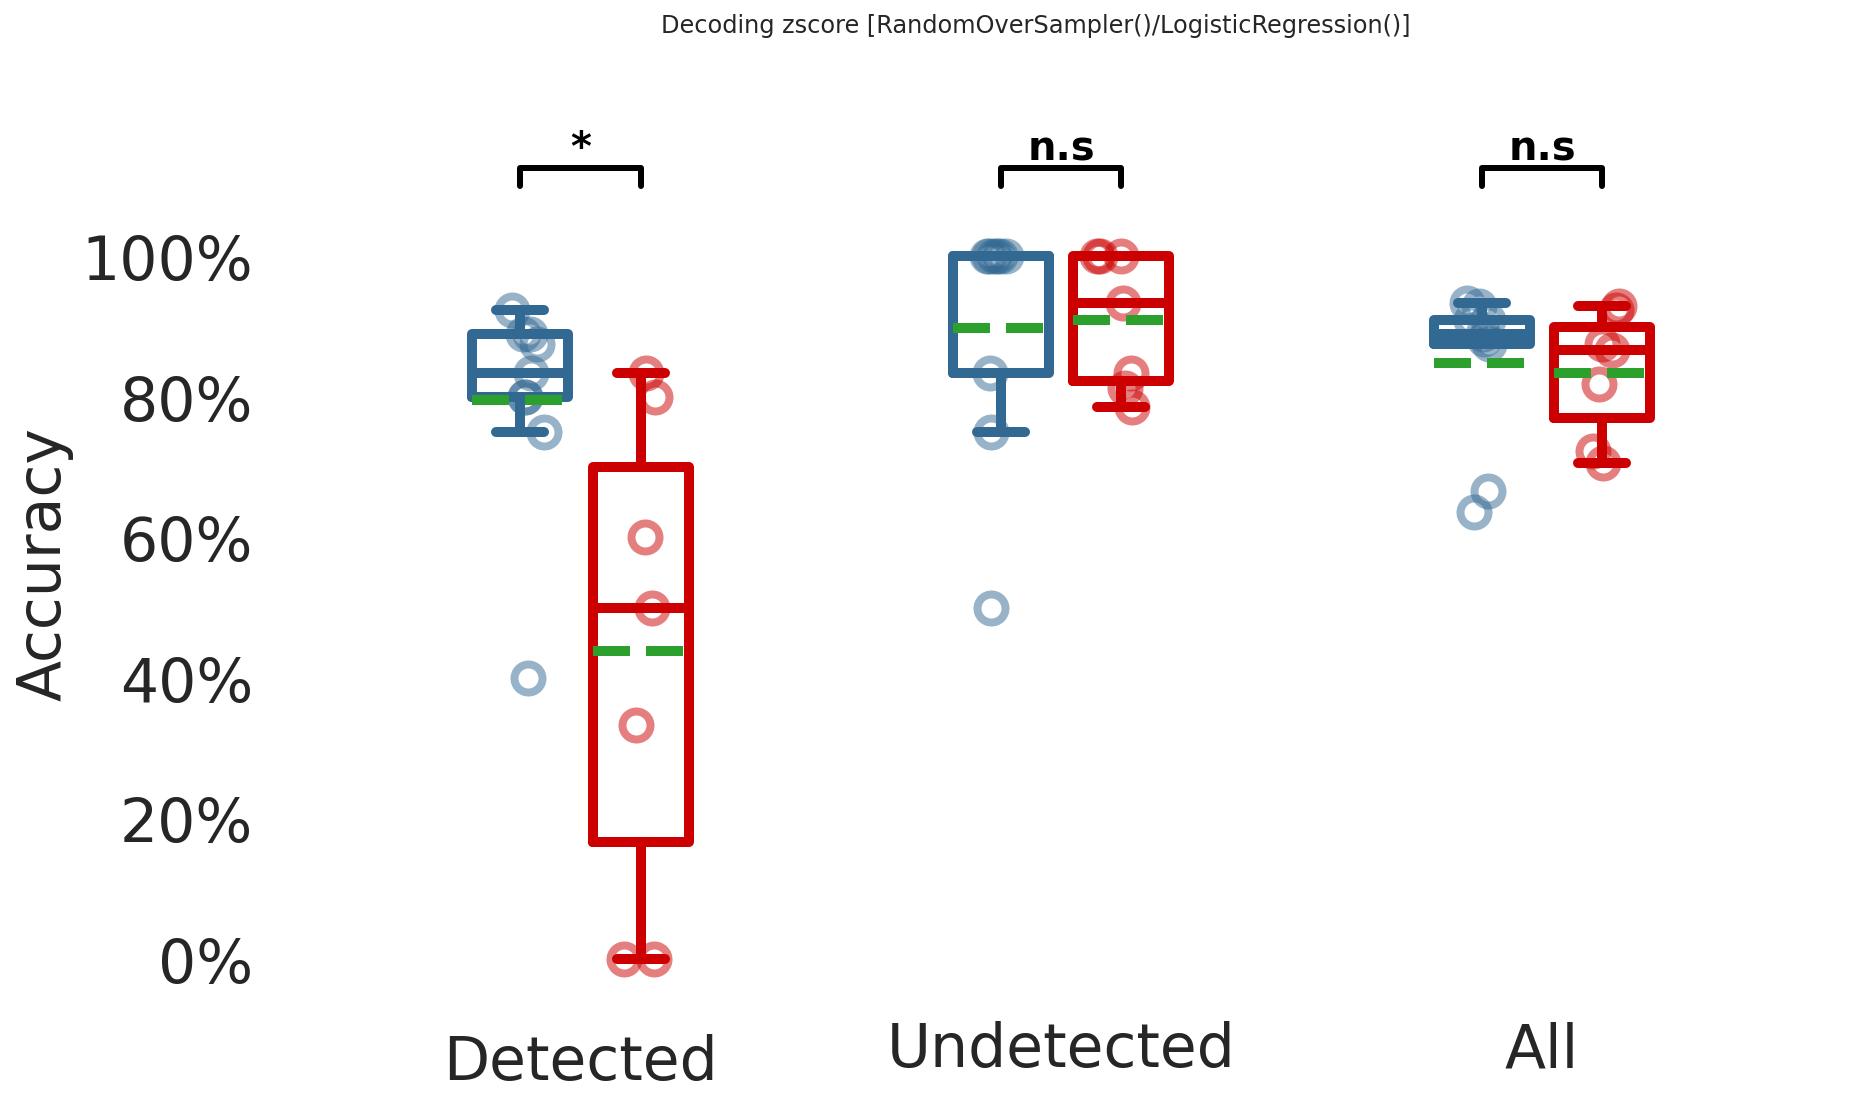

In [46]:
apply_model(lr, "zscore", estimator="Mean", resampler=ros, exc_neurons=True, inh_neurons=True, amplitudes="all", train_ratio=0.8, cv=5, stratify=True, seed=seed)

# Decoding Std zscore

---

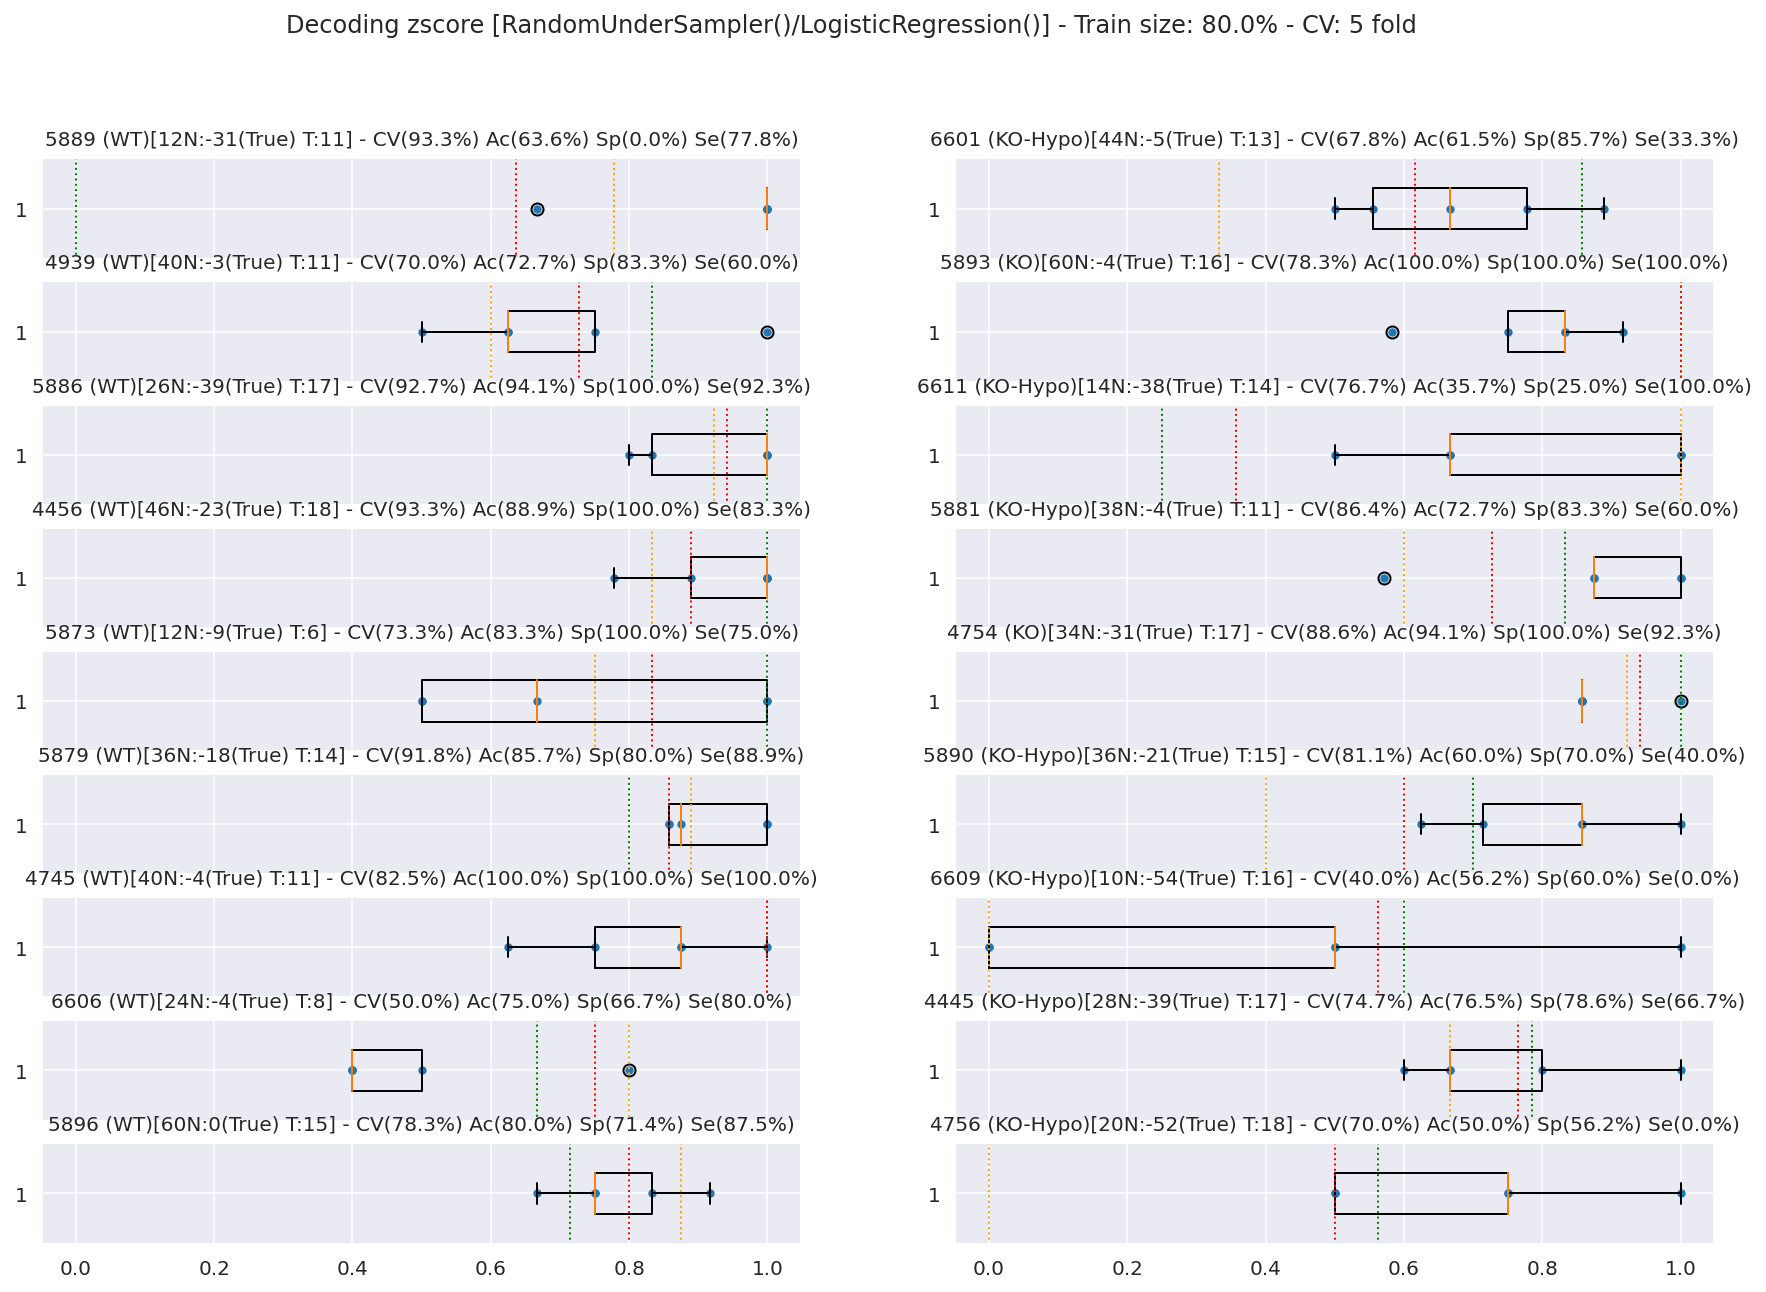

--- Detected group comp ---
ShapiroResult(statistic=0.9710698127746582, pvalue=0.9037210941314697)
ShapiroResult(statistic=0.9423982501029968, pvalue=0.6604072451591492)
LeveneResult(statistic=6.677908315734813, pvalue=0.02163353656297569)
Unequal variances: Ttest_indResult(statistic=3.129954118263971, pvalue=0.007379876348675474)
--- Undetected group comp ---
ShapiroResult(statistic=0.7254339456558228, pvalue=0.002809641882777214)
ShapiroResult(statistic=0.8855253458023071, pvalue=0.25212550163269043)
MannwhitneyuResult(statistic=45.5, pvalue=0.14967180134478916)
--- All group comp ---
ShapiroResult(statistic=0.9942060708999634, pvalue=0.9994664788246155)
ShapiroResult(statistic=0.9637925028800964, pvalue=0.8505356907844543)
LeveneResult(statistic=0.10277919519435032, pvalue=0.7532548568187403)
Equal variances :Ttest_indResult(statistic=3.7960768967036156, pvalue=0.0019659800745254604)


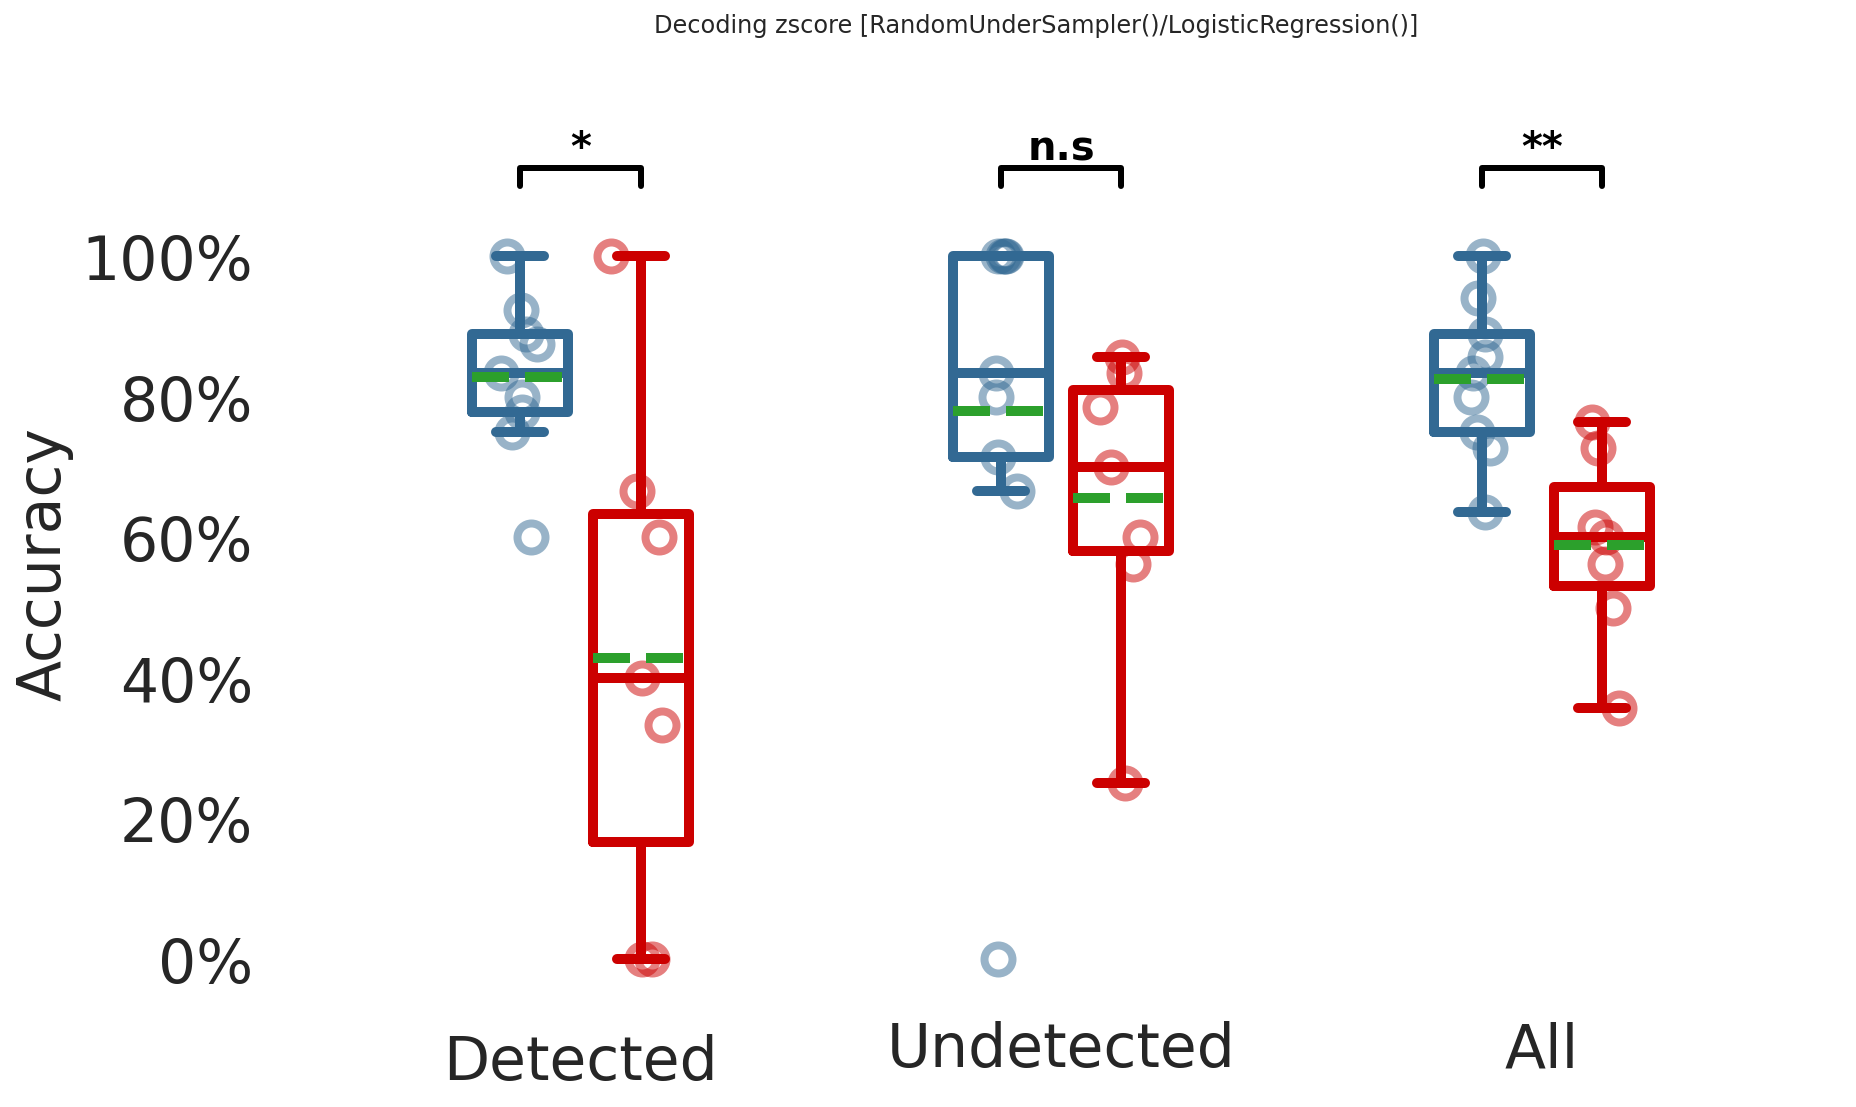

In [51]:
apply_model(lr, "zscore", estimator="Std", resampler=rus, exc_neurons=True, inh_neurons=True, amplitudes="all", train_ratio=0.8, cv=5, stratify=True, seed=seed)

# Oversampling visualization

---

In [ ]:
rec = recs[4456]
test = get_rec_info(rec, "Responsivity", exc_neurons=True, inh_neurons=True)
test = stim_ampl_filter(test, "threshold")
ros = imb.over_sampling.RandomOverSampler(sampling_strategy='auto', shrinkage=None)
# bd_smote = imb.over_sampling.BorderlineSMOTE(sampling_strategy='auto')
# adasyn = imb.over_sampling.ADASYN(sampling_strategy="auto")
test = split_data(test, train_ratio=0.8, stratify=True)

test = resample(test, ros)
# test_2 = resample(copy.copy(test), smote)
# test_3 = resample(copy.copy(test), bd_smote)
# test_4 = resample(copy.copy(test), adasyn)
resp_heatmap(test, sort=True)
# resp_heatmap(test_2, sort=True)
# resp_heatmap(test_3, sort=True)
# resp_heatmap(test_4, sort=True)